# GWAS_DepMap_PCA
predicting gwas scores using DepMap dataset's PCs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [4]:
sigmas, metadata, gene_lists = munge_sigma('HDL_cholesterol.genes.raw')

In [5]:
# create covariates from pops
covariates = []
for i in range(0, 22):
    #print(i)
    covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                   index = gene_lists[i],
                                   columns = ['genesize',
                                              'log_genesize',
                                              'genedensity',
                                              'log_genedensity',
                                              'inverse_mac',
                                              'log_inverse_mac'])
                      )
covariates = pd.concat(covariates)

In [6]:
covariates

,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
ENSG00000187634,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
ENSG00000188976,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
ENSG00000187961,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
ENSG00000187583,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
ENSG00000187642,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...
ENSG00000008735,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
ENSG00000100299,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
ENSG00000251322,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
ENSG00000100312,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Load Embeddings

In [7]:
emb_path = 'DepMap_raw_d81_0.92Variance.tsv'

In [8]:
# load embedding
emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
emb

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.662573,1.580746,0.514473,-2.047583,1.142320,-0.928176,-0.493192,-0.795099,-0.624842,1.283762,...,-1.122160,-0.156809,0.869302,0.642558,1.745312,0.980833,0.170328,-0.149983,-0.693770,-0.590241
ENSG00000148584,0.656909,0.160602,-0.343535,-0.239649,0.602858,-0.555150,-0.281376,-0.623728,0.912098,-1.038547,...,0.270334,1.727173,-1.629904,-1.420185,0.644330,-0.639475,0.550903,0.028425,-0.059058,-0.276747
ENSG00000175899,0.351229,-0.796989,-0.308368,0.240197,0.108242,0.967612,0.302968,-0.017770,-0.004008,0.189885,...,0.315137,0.452606,-0.300193,0.759897,0.771527,-0.342819,-0.357698,0.701593,-0.343082,-0.481842
ENSG00000166535,0.973488,0.845236,-0.021039,-0.194928,0.698380,-0.029739,0.218153,0.302417,0.131051,-0.350795,...,0.150545,-0.631313,-0.994629,1.271951,1.243123,-0.353998,0.078321,1.063687,1.052222,-0.059171
ENSG00000184389,0.277949,-0.318211,-0.908178,0.731876,0.610990,-0.608975,0.165754,-0.166532,-0.581511,-0.711019,...,-0.717171,0.422511,-0.110117,-0.472995,-1.189791,-0.192161,1.132779,-0.715001,1.557746,-0.358701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000203995,0.613893,-0.168261,-0.745667,-0.025008,0.470470,1.025984,-0.082433,0.212591,0.935575,1.050750,...,1.487642,1.061240,0.268649,1.092679,-0.060096,0.818856,-0.719620,0.741012,-0.574340,-0.325968
ENSG00000162378,-0.094403,-1.058173,-0.744172,1.180167,-1.183483,-1.528817,0.618991,-1.330132,-0.442867,-0.702732,...,1.935993,-0.709513,-0.164563,0.506605,-0.913298,-0.319401,1.157611,1.641553,0.869964,-0.774325
ENSG00000159840,0.732689,0.398966,-0.850592,-0.252327,0.403787,1.376202,-1.914381,-0.097586,-1.545848,-0.373463,...,0.660607,-1.354713,0.569854,-0.640666,-1.577587,-0.010468,0.466455,0.416132,1.328183,-1.049291


### Load GWAS MAGMA Scores

In [9]:
magma = pd.read_csv('HDL_cholesterol.genes.out', delim_whitespace=True)
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050
...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472


### Merge Data

In [10]:
magma = magma.merge(covariates, left_on = "GENE", right_index = True)

In [11]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Project Y to LY

In [12]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [13]:
Ls = compute_Ls(sigmas, magma.ZSTAT)

def project_Y(Ls, magma_Z):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

magma = magma.merge(project_Y(Ls, magma))

In [14]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac,LY
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878,0.999534
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951,1.551349
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390,1.148646
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457,0.708156
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071,1.854531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268,0.512377
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111,1.098611
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722,0.082490
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048,0.569190


### Merge Data

In [15]:
# merge with embedding
dt = magma.merge(emb, left_on = "GENE", right_on = "gene_id")

In [16]:
dt

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,...,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,2.909200e-02,21.0,...,-2.373385,-1.138509,-0.342230,-1.276515,0.591615,-0.545620,1.049176,0.367245,-0.668061,1.098839
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,1.046900e-03,11.0,...,-1.405357,-1.042313,0.783370,0.031026,-0.136564,-0.070628,2.292140,1.024194,0.795561,-0.218738
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,1.319900e-03,7.0,...,-0.242091,-0.013565,0.249591,-0.987492,0.329900,-0.858017,-0.758726,0.576451,0.221696,1.029609
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,2.809500e-02,19.0,...,0.216960,-0.153859,0.292603,-1.504224,0.448537,1.538554,-0.185763,-0.577154,1.157286,0.468640
4,ENSG00000188290,1,934342,935552,4,2,422405,4.84110,6.454500e-07,2.0,...,-1.136361,-0.390263,0.842810,-0.200486,1.112130,-0.466185,1.327081,-0.649959,-0.555515,1.568929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16069,ENSG00000205560,22,51007290,51017899,56,10,422405,2.79560,2.590300e-03,10.0,...,0.813577,-0.318574,0.617105,0.283870,-0.694064,0.252931,0.894066,0.228822,0.712628,-0.119739
16070,ENSG00000100288,22,51017378,51039884,121,22,422405,2.37480,8.780300e-03,22.0,...,-0.545982,1.226077,0.022874,0.253630,1.489925,0.091287,0.784018,-0.770226,0.340122,0.198482
16071,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,2.761200e-03,12.0,...,-0.344575,1.062889,-1.517344,-0.413904,0.423885,0.175618,1.134783,0.795483,0.159064,0.159101
16072,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,9.047200e-02,10.0,...,1.332158,0.258868,1.382556,-0.583259,-0.586659,-0.298267,-0.626673,0.565567,-0.456922,1.095001


## Regression by XGBRegressor

Split by Chromosomes.

In [17]:
df = []

for chrom in range(1,23):
    reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecate

Chrom 1: R2 (null): 0.0515749063077548
Chrom 1: R2: 0.05258882709882122


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 2: R2 (null): 0.09695104909377872
Chrom 2: R2: 0.08432163026849274


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 3: R2 (null): 0.054342135694040596
Chrom 3: R2: 0.05496982504117068


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 4: R2 (null): 0.05408761940583215
Chrom 4: R2: 0.051503502005589306


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 5: R2 (null): 0.0787007929554976
Chrom 5: R2: 0.08110464040114766


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 6: R2 (null): 0.031738667724924494
Chrom 6: R2: 0.025055155127595256


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 7: R2 (null): 0.03565371541872436
Chrom 7: R2: 0.027419969034755215


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 8: R2 (null): 0.05698979862203191
Chrom 8: R2: 0.06111531896793547


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 9: R2 (null): 0.055872651089833726
Chrom 9: R2: 0.03838235022666276


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 10: R2 (null): 0.054578355832046115
Chrom 10: R2: 0.04788089200122301


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 11: R2 (null): 0.03446698773497381
Chrom 11: R2: 0.036463762356937435


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 12: R2 (null): 0.043418026247709594
Chrom 12: R2: 0.04263479529878554


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 13: R2 (null): 0.07050173053951976
Chrom 13: R2: 0.045208131343806114


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 14: R2 (null): 0.04144510597512324
Chrom 14: R2: 0.04052768481285218


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 15: R2 (null): 0.07339676423535157
Chrom 15: R2: 0.07120248342744227


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 16: R2 (null): 0.047520253797754
Chrom 16: R2: 0.03798822629455939


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 17: R2 (null): 0.0295466185415806
Chrom 17: R2: 0.0304446117116624


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 18: R2 (null): 0.02208827253838131
Chrom 18: R2: 0.04338515313057494


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 19: R2 (null): 0.03678091870982566
Chrom 19: R2: 0.02385766435592024


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 20: R2 (null): 0.044799427756084836
Chrom 20: R2: 0.07017885912145097


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecate

Chrom 21: R2 (null): 0.1645041779153743
Chrom 21: R2: 0.16831019908804587


/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Chrom 22: R2 (null): 0.007167157713592936
Chrom 22: R2: 0.009295943068284088

Overall R2 (null): 0.08202625970177262
Overall R2: 0.08494627455860772


In [18]:
df

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,LY,pred_LY_null,pred_LY,pred_null,pred
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,2.909200e-02,0.999534,0.825410,1.036981,1.564303,1.965268
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,1.046900e-03,1.551349,0.566763,0.583266,1.204307,1.272100
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,1.319900e-03,1.148646,0.642082,0.792974,1.606712,1.940211
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,2.809500e-02,0.708156,0.878792,0.960749,1.983819,2.198319
4,ENSG00000188290,1,934342,935552,4,2,422405,4.84110,6.454500e-07,2.205382,0.475356,0.521921,1.076521,1.187106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16069,ENSG00000205560,22,51007290,51017899,56,10,422405,2.79560,2.590300e-03,1.420457,0.682951,0.677007,1.734502,1.749652
16070,ENSG00000100288,22,51017378,51039884,121,22,422405,2.37480,8.780300e-03,0.995481,0.873035,0.857106,2.280659,2.260195
16071,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,2.761200e-03,1.098611,0.773258,0.675149,2.048504,1.853757
16072,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,9.047200e-02,0.569190,0.727660,0.802232,1.659534,1.793930


In [19]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

# df.to_csv(snakemake.output.pred, sep = '\t')

Per chrom R2 (full):
0.06280004548653313
0.04782478642905696
0.15891869696384772
0.06420555888374394
0.06839178141895604
0.22955554161568784
0.022537426414029376
0.05265541462490457
0.047059033179588476
0.0408591223765341
0.09274101604481573
0.07005323731374949
0.03724491095072436
0.07700088013322964
0.09289482833004724
0.12544638063423458
0.0471225158700001
0.0494635960938817
0.01799801184142648
0.2247610256552697
0.1961399010817481
0.0798366705032176


In [20]:
#scatter plot (of the predicted vs. the true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

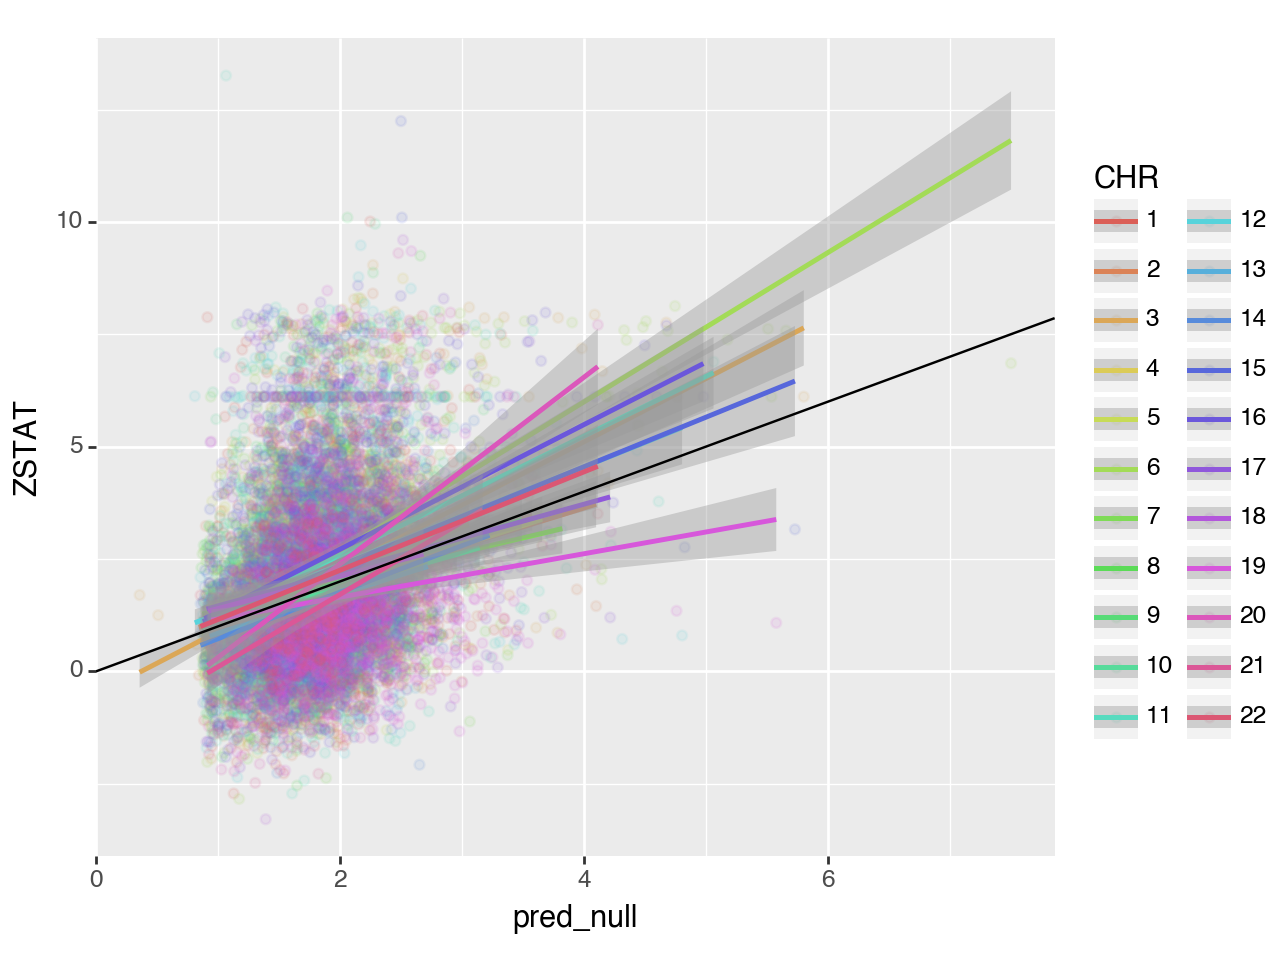

<Figure Size: (640 x 480)>

In [21]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = "CHR", smooth=True)

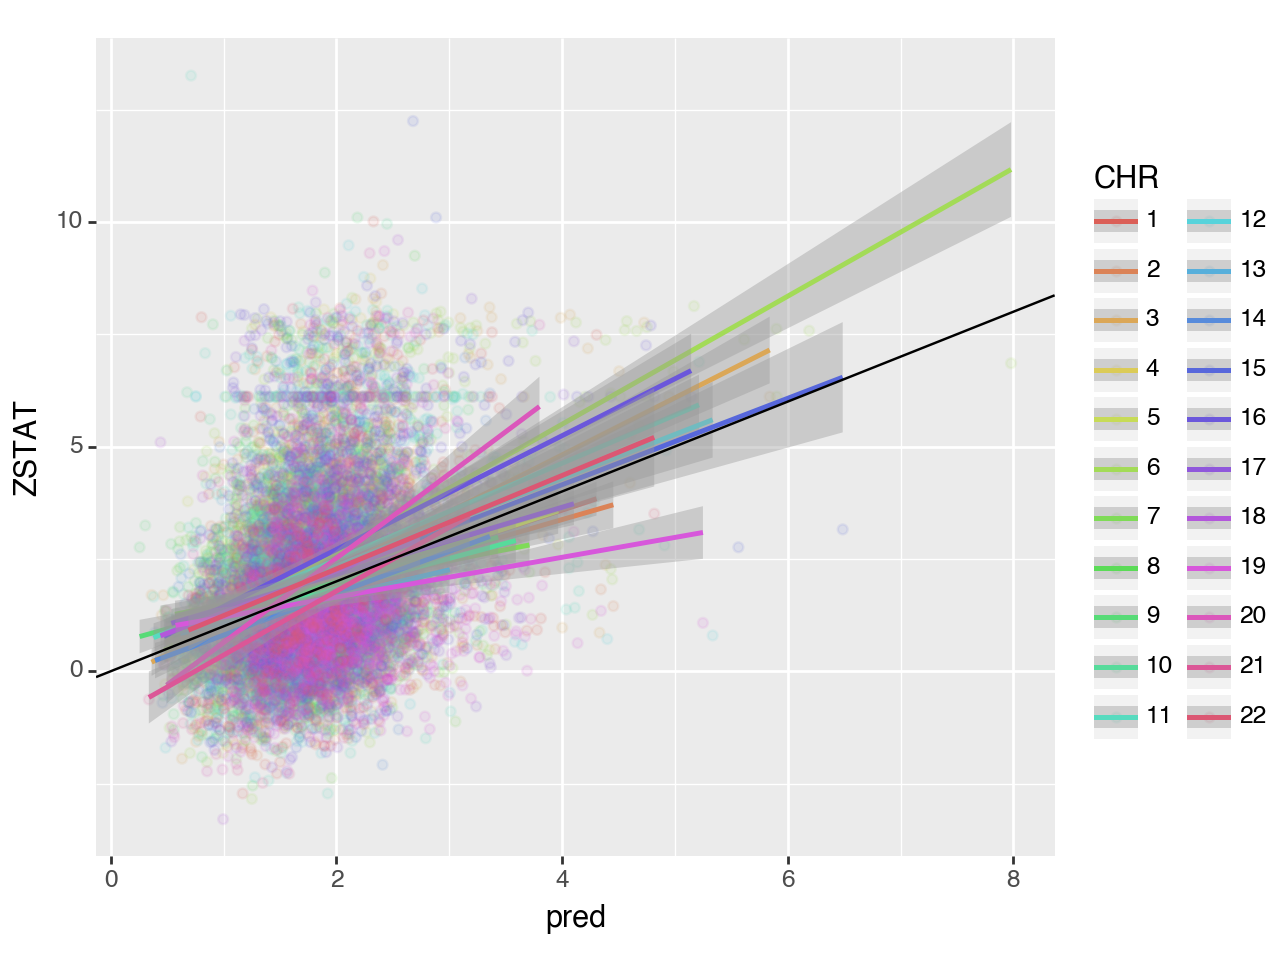

<Figure Size: (640 x 480)>

In [22]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = "CHR", smooth=True)

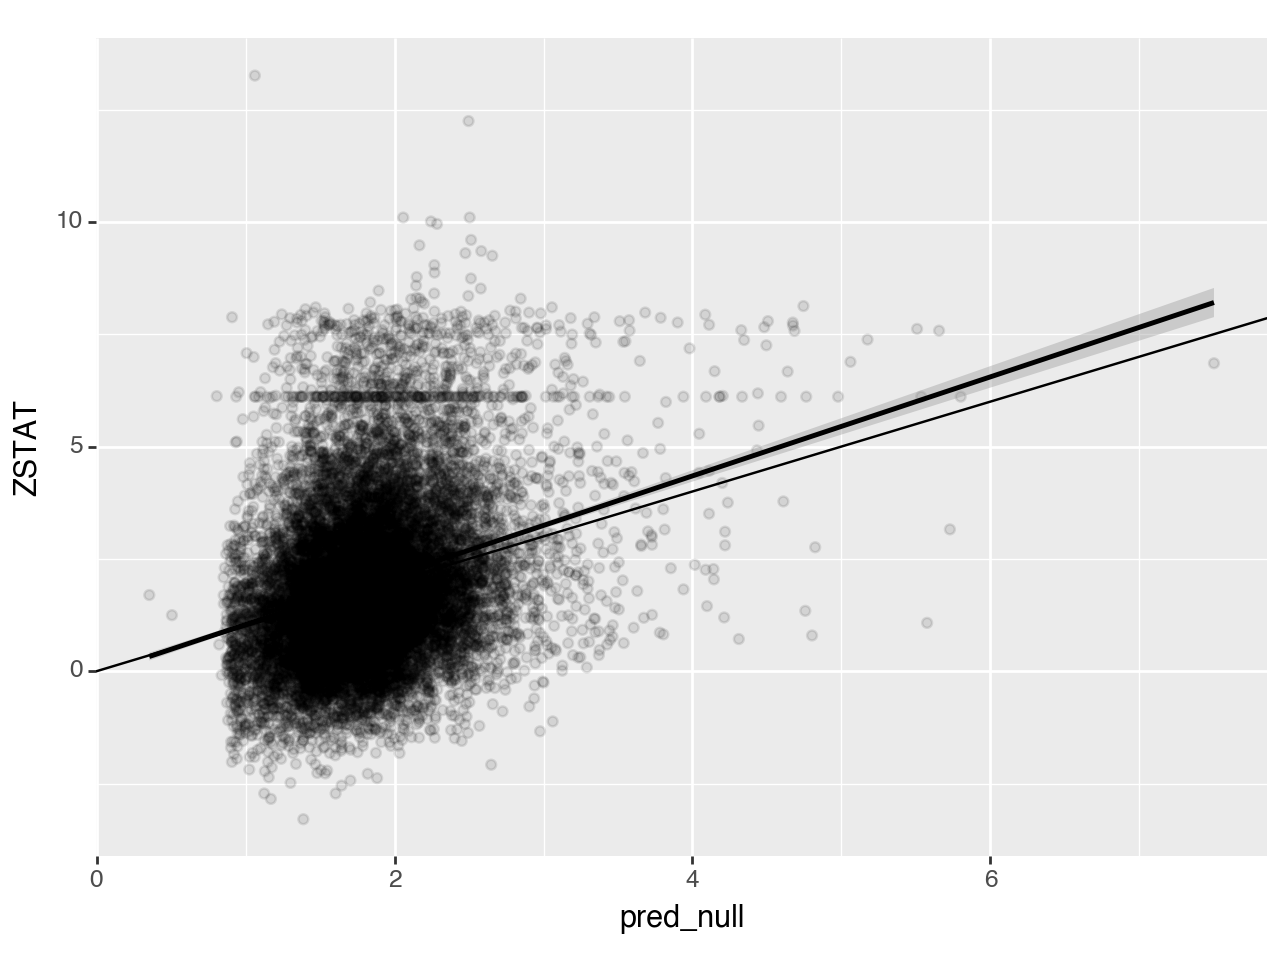

<Figure Size: (640 x 480)>

In [23]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = None, smooth=True)

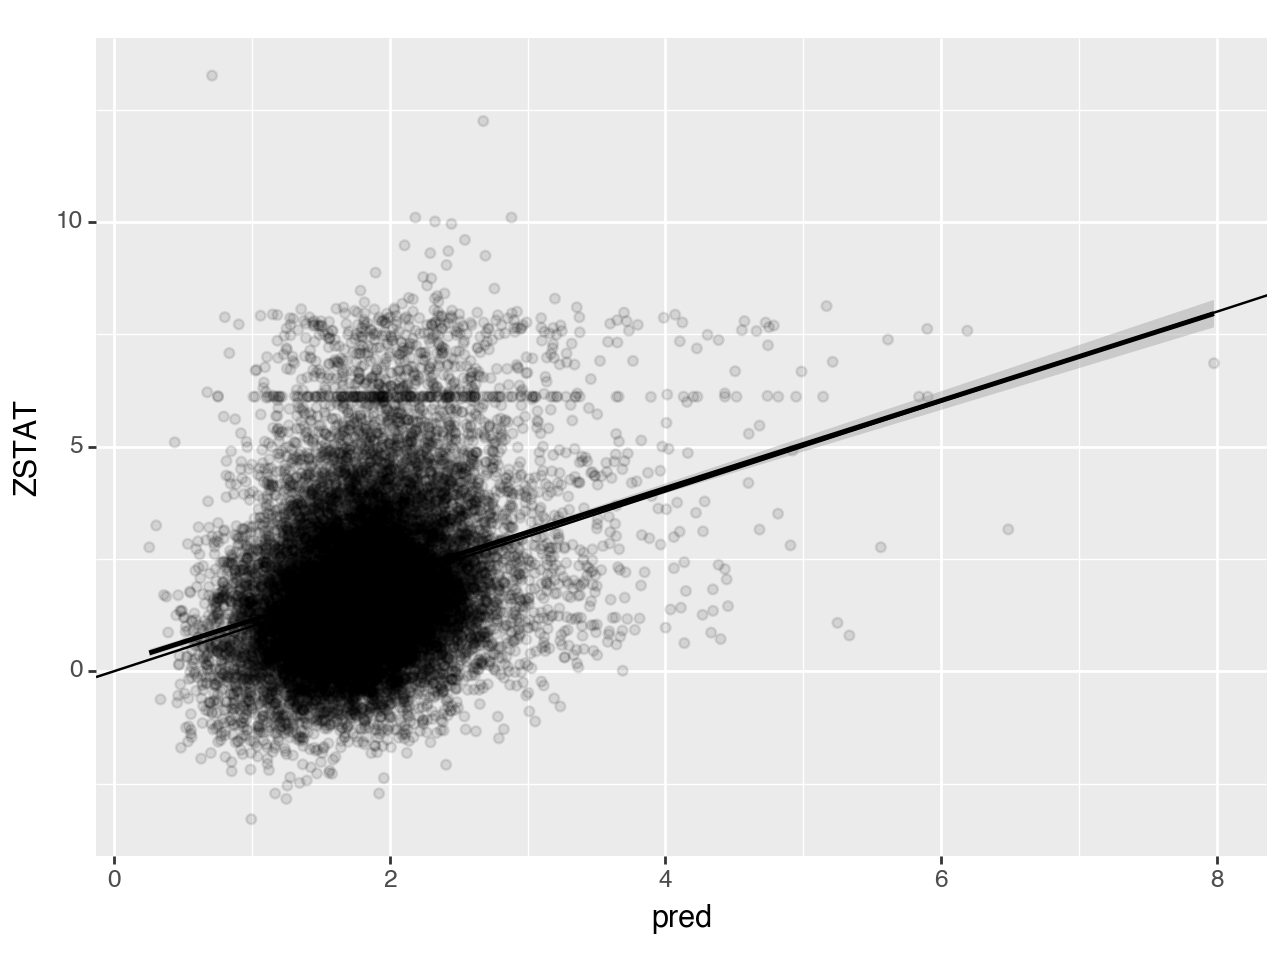

<Figure Size: (640 x 480)>

In [24]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = None, smooth=True)

In [25]:
#plot the r score
def plot_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        "r2_null": np.array(r2_null),
        "r2_full": np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=["r2_null", "r2_full"], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()
    return p1, p2

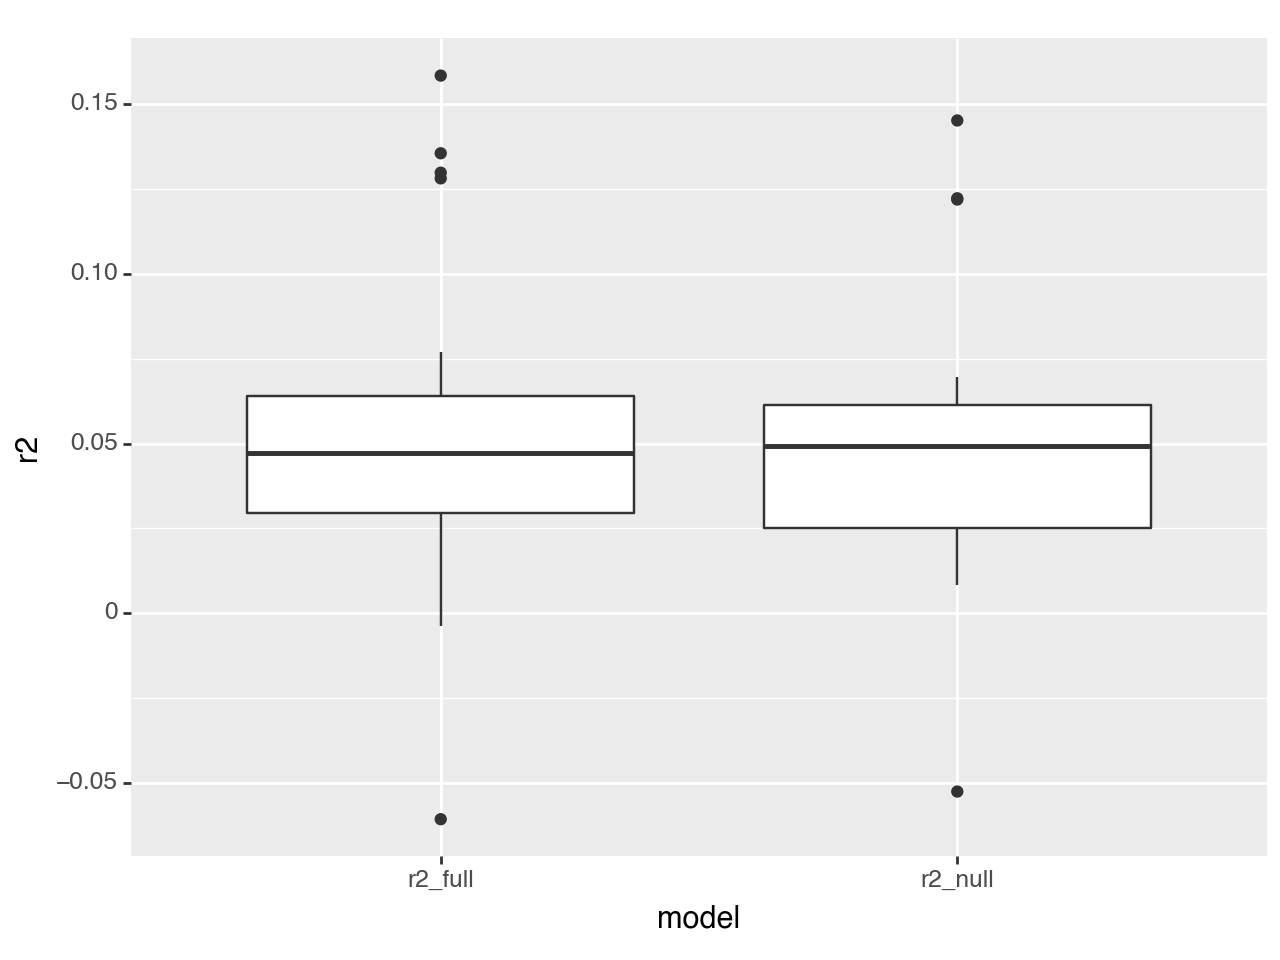

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


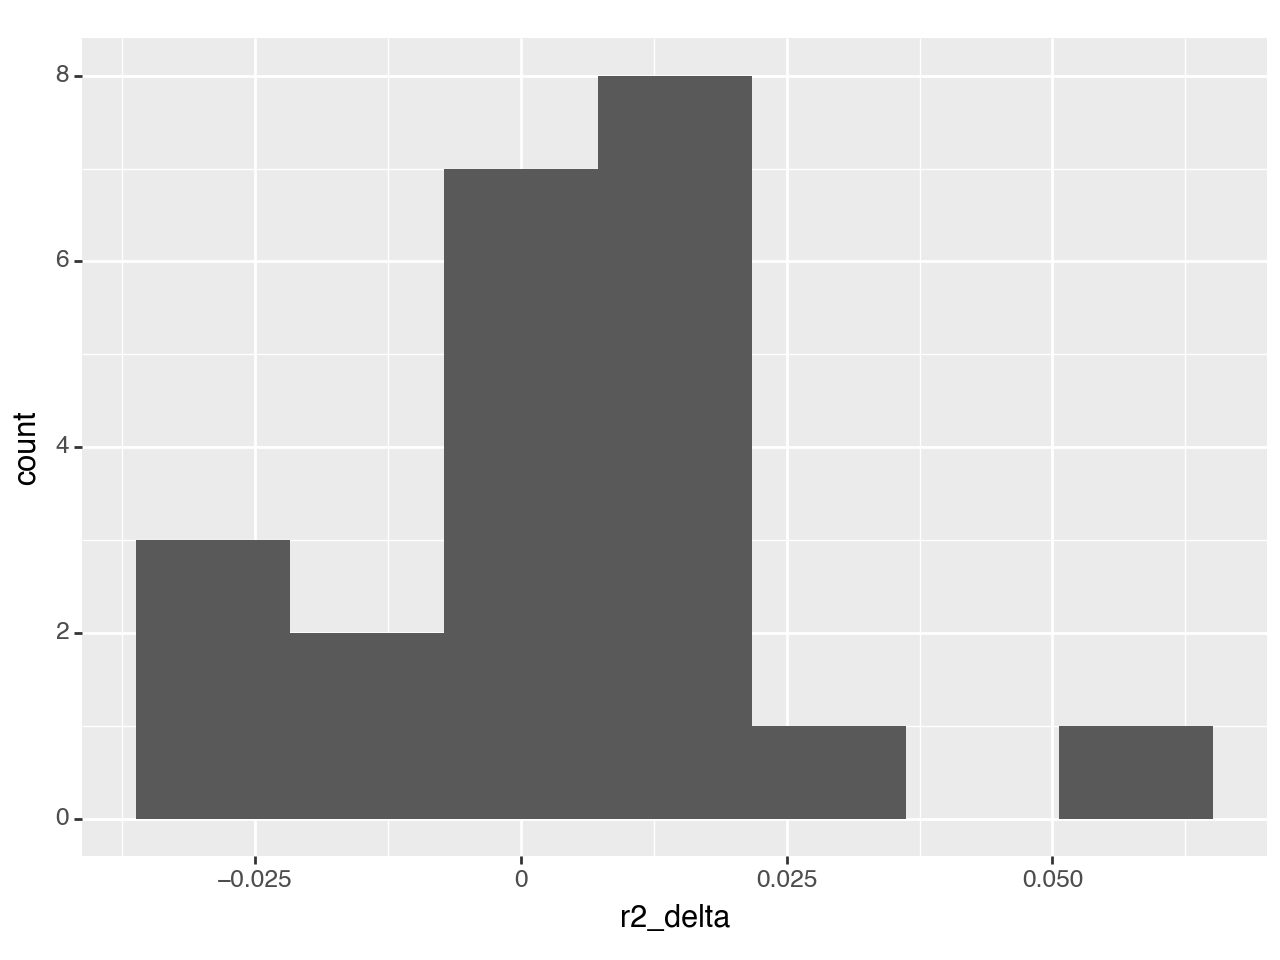

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [26]:
plot_r2(df)

## Regression by Linear Regressor


In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
df = []

for chrom in range(1,23):
    reg_null = LinearRegression()
    reg_full = LinearRegression()
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

Chrom 1: R2 (null): 0.04680622159487567
Chrom 1: R2: 0.056466836085541754
Chrom 2: R2 (null): 0.10776781767965439
Chrom 2: R2: 0.09073424395852282
Chrom 3: R2 (null): 0.06217056316832293
Chrom 3: R2: 0.06469833563602723
Chrom 4: R2 (null): 0.052579049027801826
Chrom 4: R2: 0.04603145891108215
Chrom 5: R2 (null): 0.0789622345665655
Chrom 5: R2: 0.08970160568739909
Chrom 6: R2 (null): 0.02601766411884917
Chrom 6: R2: 0.02862836511307594
Chrom 7: R2 (null): 0.04339782222421168
Chrom 7: R2: 0.03796739027557057
Chrom 8: R2 (null): 0.07106616262830814
Chrom 8: R2: 0.07025043171826095
Chrom 9: R2 (null): 0.0536619341338917
Chrom 9: R2: 0.04298364694278513
Chrom 10: R2 (null): 0.0653811357027914
Chrom 10: R2: 0.05901444401386277
Chrom 11: R2 (null): 0.037079982044560256
Chrom 11: R2: 0.04113384663945171
Chrom 12: R2 (null): 0.03594970595692965
Chrom 12: R2: 0.037672730037235244
Chrom 13: R2 (null): 0.07616960153983343
Chrom 13: R2: 0.04008417695193449
Chrom 14: R2 (null): 0.03834997272347664
C

In [29]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

Per chrom R2 (full):
0.07083693091147847
0.054682653863056783
0.15881258228322878
0.057673284744397854
0.07824733641496426
0.22465337279067846
0.028983541593805288
0.062248356605001
0.050232582853749666
0.04925713656626309
0.09634065135880766
0.059545360924837414
0.0336056504792628
0.06790104062194138
0.10259167918711454
0.11891612709880738
0.05328822903211623
0.05148940813752038
0.024760263431353492
0.21783862510044694
0.20558586365835957
0.06337548928776943


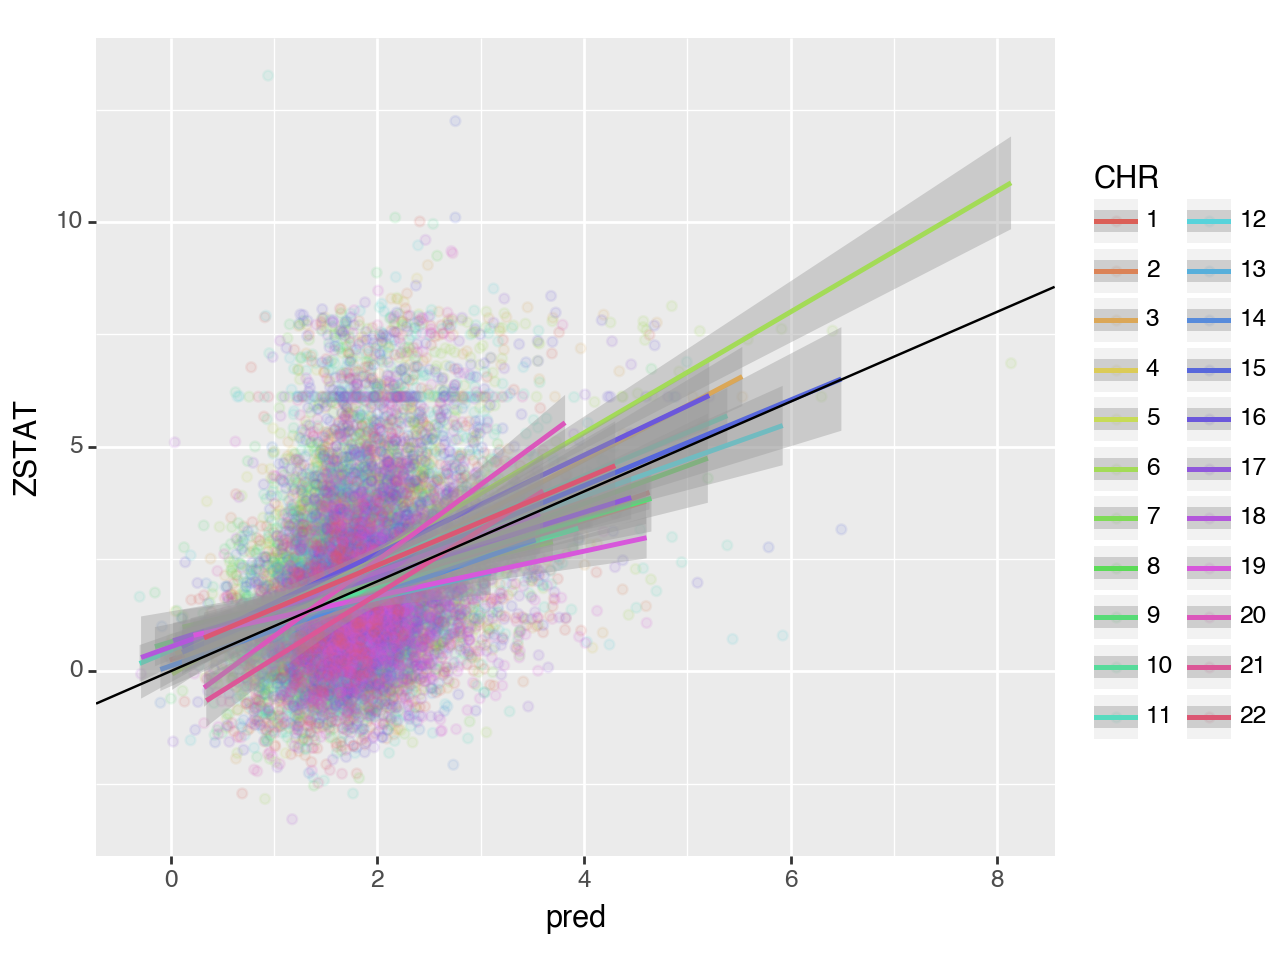

<Figure Size: (640 x 480)>

In [30]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = "CHR", smooth=True)

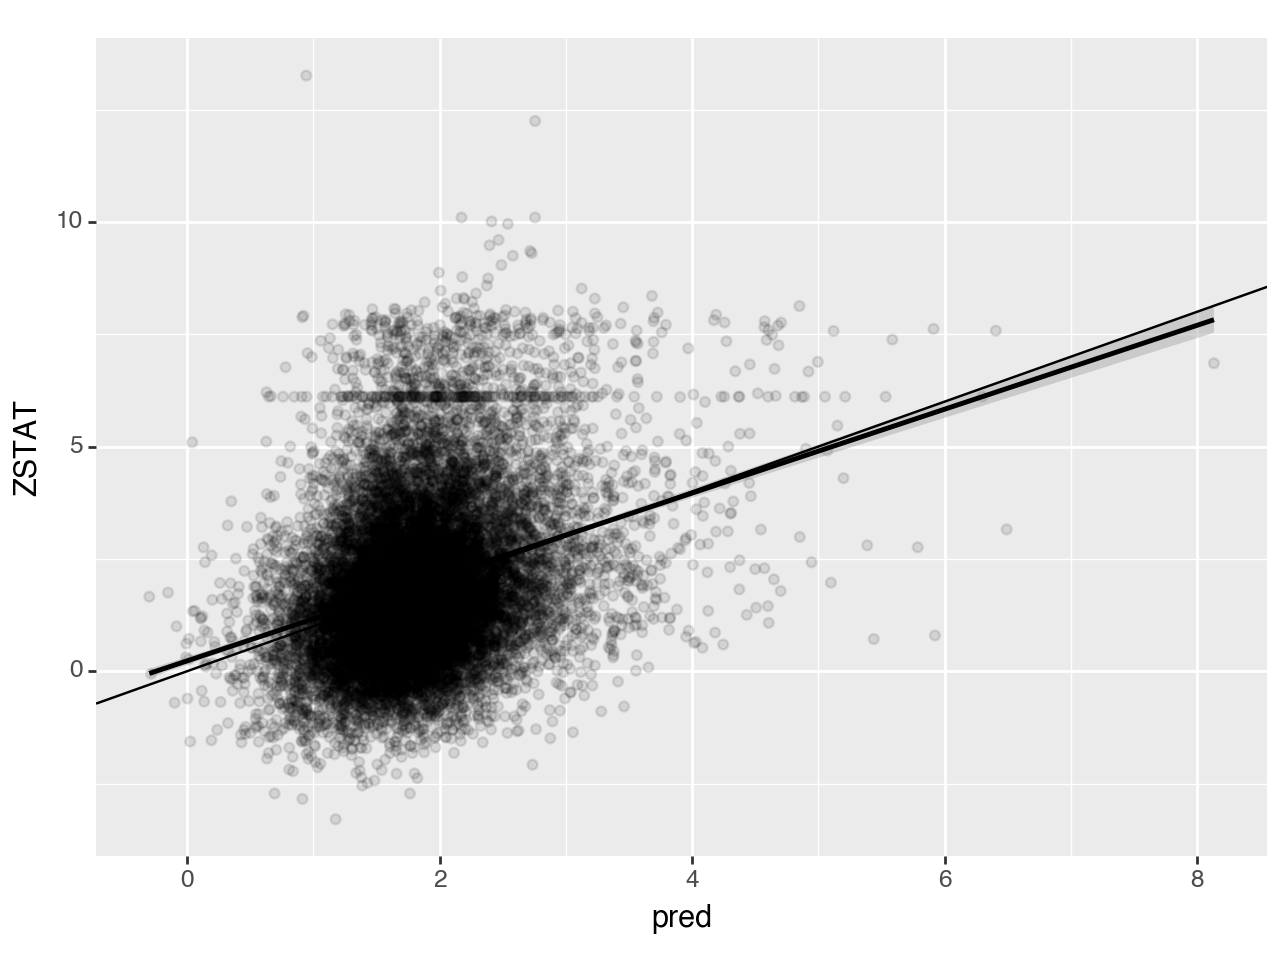

<Figure Size: (640 x 480)>

In [31]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = None, smooth=True)

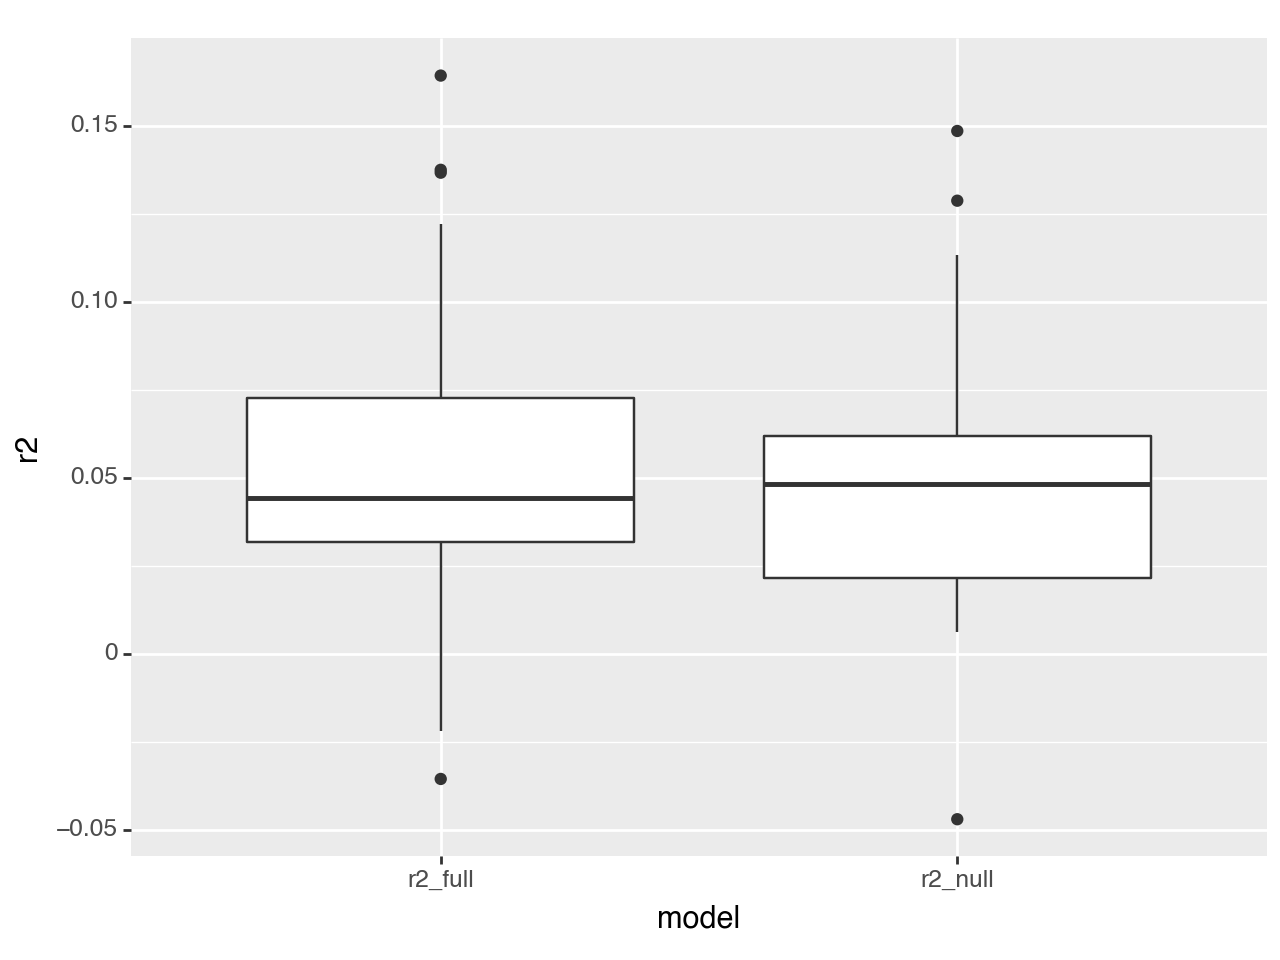

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 5'. Pick better value with 'binwidth'.


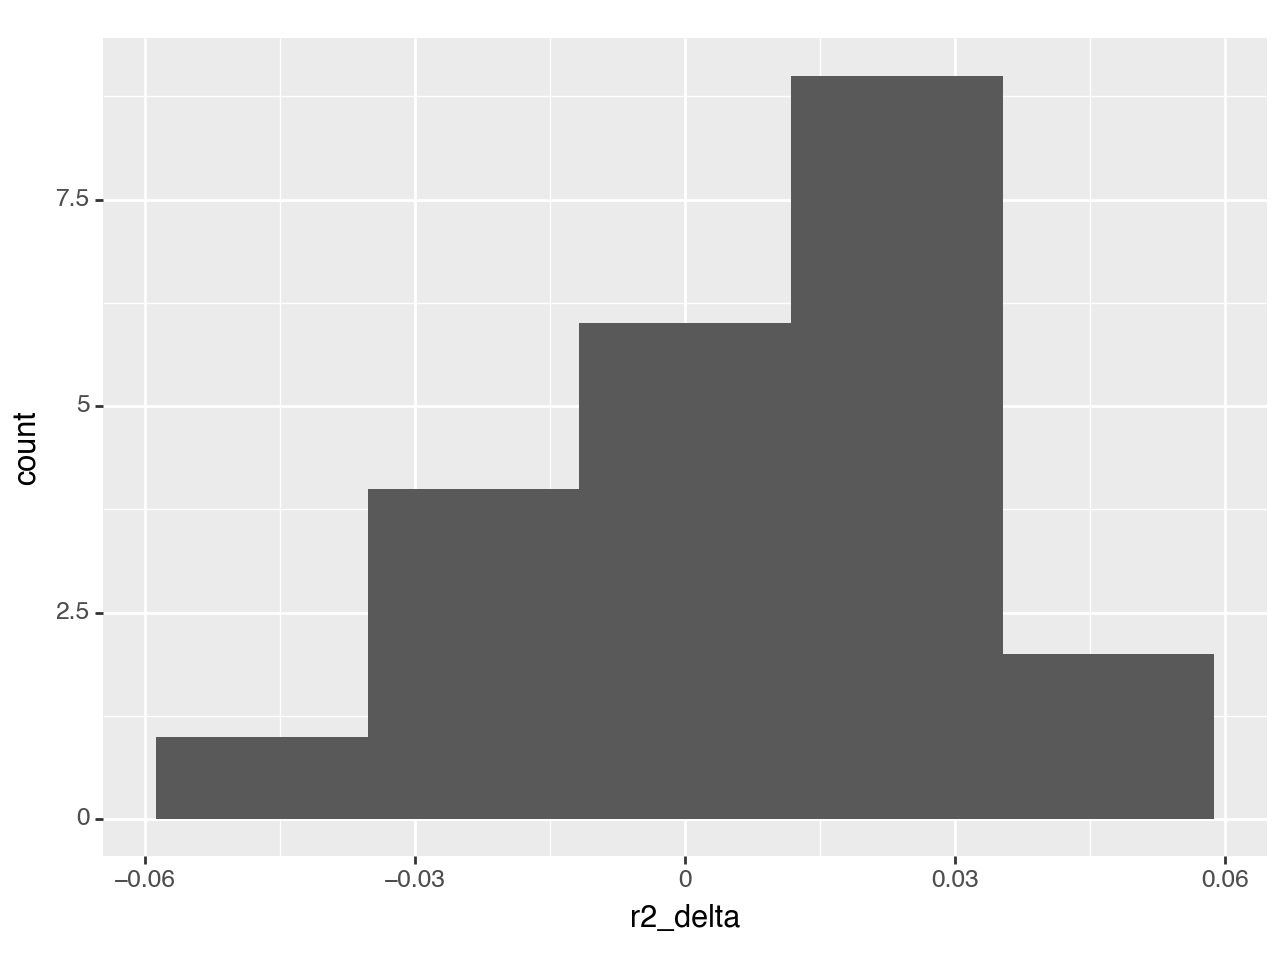

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [32]:
plot_r2(df)

## Regression by ElasticNet

In [33]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GroupKFold

In [34]:
df = []

for chrom in range(1,23):
    gkf = GroupKFold(n_splits=5)
    reg_null = ElasticNetCV(cv=gkf.split(dt.query("CHR != @chrom")['LY'], 
                                dt.query("CHR != @chrom")['LY'], 
                                groups = dt.query("CHR != @chrom")['CHR']),
                                random_state=0, fit_intercept=True)
    
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    gkf = GroupKFold(n_splits=5)
    reg_full = ElasticNetCV(cv=gkf.split(dt.query("CHR != @chrom")['LY'], 
                                dt.query("CHR != @chrom")['LY'], 
                                groups = dt.query("CHR != @chrom")['CHR']),
                                random_state=0, fit_intercept=True)
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

Chrom 1: R2 (null): 0.04668150103162868
Chrom 1: R2: 0.0568040204460949
Chrom 2: R2 (null): 0.10903604183071047
Chrom 2: R2: 0.0965803636145666
Chrom 3: R2 (null): 0.05902190052520076
Chrom 3: R2: 0.0613196247172291
Chrom 4: R2 (null): 0.05164154379283976
Chrom 4: R2: 0.05000957191872453
Chrom 5: R2 (null): 0.08183578139289913
Chrom 5: R2: 0.08646564316793795
Chrom 6: R2 (null): 0.025168225959049984
Chrom 6: R2: 0.028170440048602852
Chrom 7: R2 (null): 0.04223357043432879
Chrom 7: R2: 0.040472263091440516
Chrom 8: R2 (null): 0.0712688948673109
Chrom 8: R2: 0.07504965075706865
Chrom 9: R2 (null): 0.06012569130516111
Chrom 9: R2: 0.05414027548913682
Chrom 10: R2 (null): 0.06563695709112953
Chrom 10: R2: 0.06479580473443958
Chrom 11: R2 (null): 0.034938618967123025
Chrom 11: R2: 0.03985660908684279
Chrom 12: R2 (null): 0.03764604763901179
Chrom 12: R2: 0.04026110047375463
Chrom 13: R2 (null): 0.07302287337826531
Chrom 13: R2: 0.05196867708850391
Chrom 14: R2 (null): 0.03654599884214837
Ch

In [35]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

Per chrom R2 (full):
0.06597731070747959
0.05358405875182423
0.1560359826440899
0.06142786445942868
0.07080932470085767
0.22824977986271391
0.029799935567838446
0.06329195166486253
0.05997605425684273
0.050671590027843424
0.09368400113134
0.05773086368314279
0.04210605488995653
0.06766140284219073
0.10481833778061525
0.13454160419212965
0.05016354451292738
0.03676673467214574
0.022917542010601307
0.20967731606212278
0.22308580498790984
0.06412747270585455


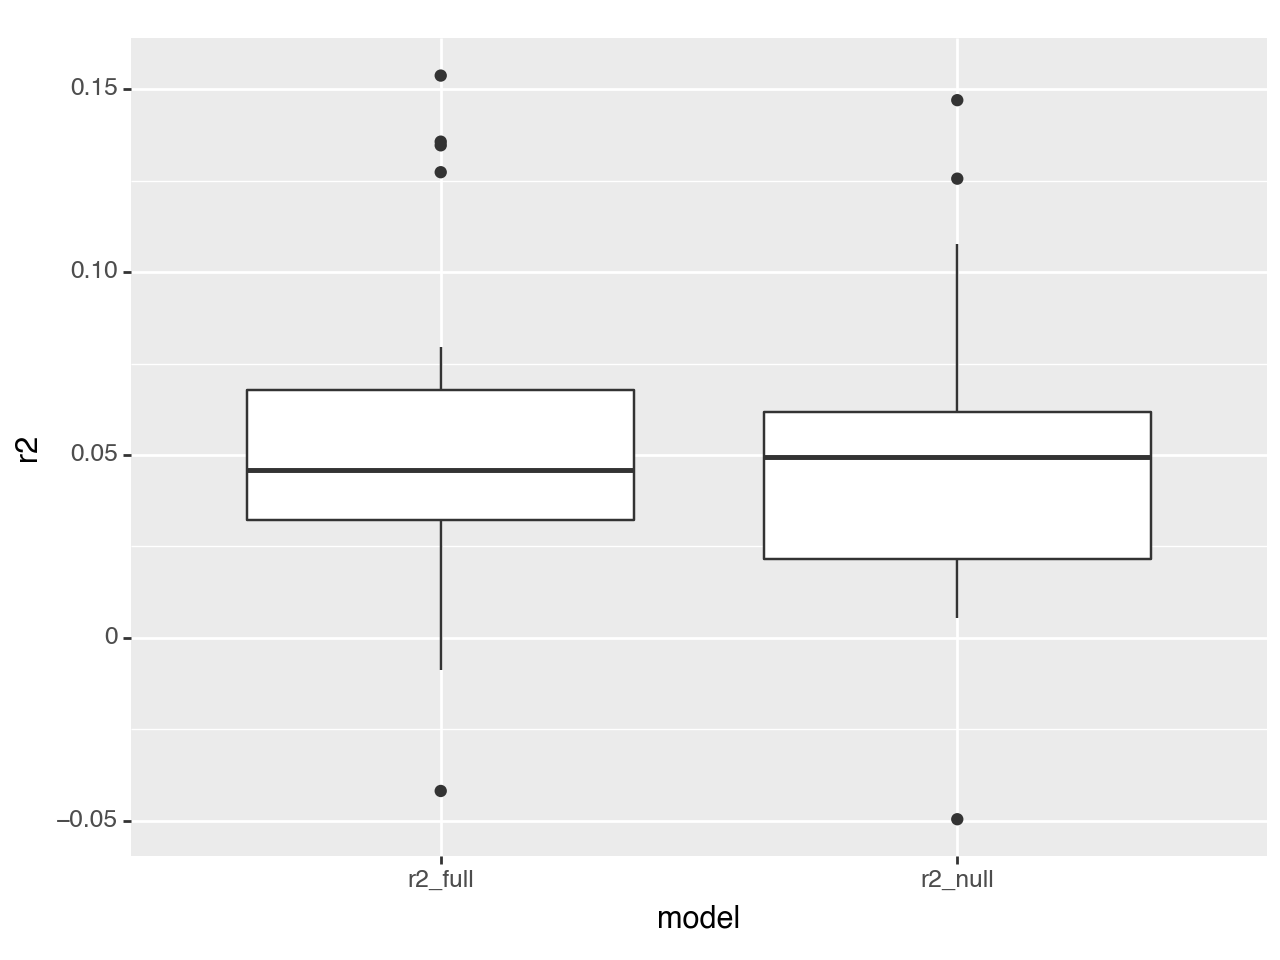

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 5'. Pick better value with 'binwidth'.


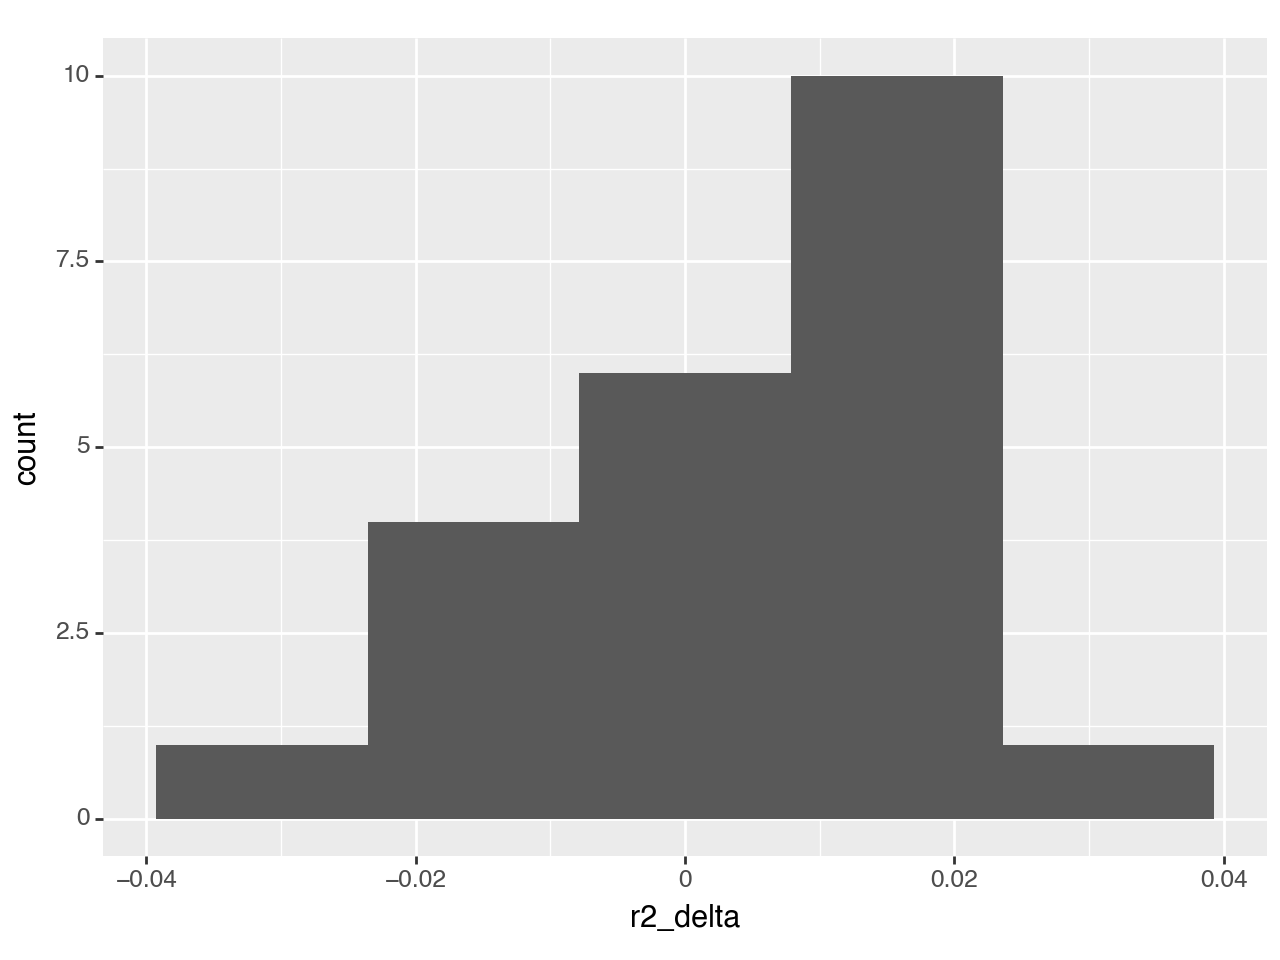

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [36]:
plot_r2(df)